# Exercise 3: More Advanced AD with Convolutional Auto-Encoders, Non-Standard Losses, And Generative Adversarial Network Anomaly Detection

### Goals of the Exercise

- Make a 2D convolutional autoencoder for events
- Explore some non-standard losses for 2D images/autoencoders
- Create a Generative Adversarial Network for anomaly detection

### More Anomaly Detection With Autoencoders

A very common form of data in particle physics (and everything else) is images. 2D maps of the visual of something. There are, of course, autoencoders for this, "convolutional autoencoders", that use the same filter based features as a traditional image classifier convolutional neural network.

Very often, data comes in 2D grids (especially for something like a detector or calorimeter), or a 2D image can be made by imposing a grid based structure on spatial data (note: this is acutally a bit non-ideal as it can lead to sparse data representations, and a whole lot of math on a whole lot of nothing, a problem that graph auto-encoders in the next exercise solve).

at this point, you know the drill, we're going to make some auto-encoders for this, and see how they do!

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from time import perf_counter

from rich.console import Console

from tensorflow import keras

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

console = Console()

def load_data(file_path: str, limit_entries: int = None) -> np.array:
    with h5py.File(file_path) as the_file:
        if limit_entries is not None:
            data = np.array(the_file['event_image_data'])[:limit_entries]
        else:
            data = np.array(the_file['event_image_data'])
    return data

nprng = np.random.default_rng(42)

#Perform random phi rotations on a dataset.
#Assumes phi index per example is the first index
def random_phi_rotations(the_data:np.array, max_shift: int =8) -> np.array:
    new_examples = []
    for example in the_data:
        shift_value = nprng.integers(-max_shift, max_shift+1)
        phi_shifted_example = np.roll(example, axis=0, shift=shift_value)
        new_examples.append(phi_shifted_example)
    new_examples = np.array(new_examples)
    return new_examples

#perform random eta reflections on a dataset
#Assume eta index per example is the second index
def random_eta_reflections(the_data: np.array)->np.array:
    new_examples = []
    for example in the_data:
        if nprng.random() >= 0.5:
            new_example = example[:, ::-1]
        else:
            new_example = example
        new_examples.append(new_example)
    new_examples = np.array(new_examples)
    return new_examples

zerobias_data = random_eta_reflections(random_phi_rotations(load_data('data/advanced_files/ZeroBiasAdvancedData.h5')))

console.print(zerobias_data.shape)

jetht_data = random_eta_reflections(random_phi_rotations(load_data('data/advanced_files/JetHTAdvancedData.h5')))

console.print(jetht_data.shape)

ttbar_data = random_eta_reflections(random_phi_rotations(load_data('data/advanced_files/TTBarAdvancedData.h5')))

console.print(ttbar_data.shape)

softqcd_data = random_eta_reflections(random_phi_rotations(load_data('data/advanced_files/SoftQCDAdvancedData.h5')))

console.print(softqcd_data.shape)

radion_data = random_eta_reflections(random_phi_rotations(load_data('data/advanced_files/RadionAdvancedData.h5')))

console.print(radion_data.shape)

(69955, 16, 16, 5)

(65014, 16, 16, 5)

(88924, 16, 16, 5)

(204361, 16, 16, 5)

(1000, 16, 16, 5)

The data I have provided here is a $16\times16$ grid of all reconstructed CMS jets, electrons, photons, muons and taus. The features, per grid cell are:

0. $p_{T}$
1. $\phi$
2. $\eta$
3. $m$
4. A simple code to denote what type of object it is. 1 for jet, 2 for electron, 3 for photon, 4 for muon, 5 for tau. I perhaps should have one-hot encoded this, but didn't, so if you want to attempt to implement that, please be my guest.

I have also done some dataset augmentation. I have randomly rotated each image in phi so that our autoencoder does not become too dependent on a specific angular setup. It, and physics should hopefully not be dependent on that. I have also randomly reflected some examples across eta. The physics here is dependent on eta, but not on the reflection, and the autoencoder should be invariant to that as well.

We're going to make a convolutional 2D auto-encoder. There are a lot of things one can do to potentially tune and make an auto-encoder like this. This section is going to be a bit more free-form and I am going to encourage you to try playing around with a bunch of them.

Some ideas to look at:
- In addition to the latent space _size_ consider whether the latent space is _flat_. One could, in theory, completely flatten out the latent space encoding via a `Flatten` layer... or via other methods with less location dependence like Global Pooling. Check how that works in the loss, and for anomaly detection. If you don't flatten it, you can instead maintain a 2D structure, but reduce the amount of information available, and later expand it outward again. Try that, alongside things like max or average pooling.
- Some may be wondering "how do I go from 2D data to a smaller or flat latent space, then back out?" [keras has reshape layers](https://keras.io/api/layers/reshaping_layers/reshape/) that can allow you to make your completely flat data 2D (or any other shape) again. If you're wondering how to go from a smaller 2D image to a larger one, a simple method is [upsampling](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) which will take a cell and duplicate it next to itself. A likely better solution are [transpose convolutional layers](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/), which behave as a convolutional layer, but in reverse, becoming in effect, learnable upsampling
- Convolutional layers have a kernel size, i.e. how many cells worth of features in each direction it uses in its filter creation. Play around with the size of those and see if it makes a difference.
- Similarly, Convolutional layers can have stride, i.e. how many cells it skips when it makes another filter calculation. Do be aware, this will change the shape when you use stride
- Convolutional neural networks can also have padding, typically "valid" padding, only using filled cells (this will also change the output image size), or "same" padding (the image is padded with empty cells until the output image would be the same size as the original input image. Play around with those and see where it goes.

I'd like to hear from some people what the best overall 2D convolutional auto-encoder they got was, in terms of ROC-AUC on both the JetHT dataset, and on the $t\bar{t}$ dataset.

In [4]:
#
# Exercise: Make a 2D convolutional auto-encoder, and try changing some of the parameters
#

zerobias_train, zerobias_testval = train_test_split(
    zerobias_data,
    test_size=0.4,
    random_state=42
)

zerobias_val, zerobias_test = train_test_split(
    zerobias_testval,
    test_size=0.2/0.4,
    random_state=42,
)

conv_ae = keras.Sequential([
    #
    # encoder
    #
    keras.layers.Input(shape=zerobias_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(
        filters=16,
        kernel_size=7,
        padding='same',
        activation='leaky_relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    #Size is now 8 x 8, 16 filters
    keras.layers.SpatialDropout2D(0.2),
    keras.layers.Conv2D(
        filters=32,
        kernel_size=3,
        padding='same',
        activation='leaky_relu'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.GlobalMaxPooling2D(),
    #
    # Final latent space size and shape: 32 flat entries
    #
    #
    # decoder
    #
    keras.layers.Dense(4*4*8, activation='leaky_relu'),
    keras.layers.Reshape((4,4,8)), #new shape is 4 x 4 with 8 features
    keras.layers.BatchNormalization(),
    keras.layers.SpatialDropout2D(0.2),

    #keras.layers.Conv2DTranspose(16, kernel_size=2, strides=2, activation='leaky_relu'), # new shape is 8 x 8 with 16 features
    keras.layers.Conv2DTranspose(16, kernel_size=5, strides=1, activation='leaky_relu'),
    keras.layers.BatchNormalization(),
    keras.layers.SpatialDropout2D(0.2),

    #keras.layers.Conv2DTranspose(32, kernel_size=2, strides=2, activation='leaky_relu'), # new shape is 16 x 16 with 32 features
    keras.layers.Conv2DTranspose(32, kernel_size=9, strides=1, activation='leaky_relu'),
    keras.layers.BatchNormalization(),
    keras.layers.SpatialDropout2D(0.2),

    keras.layers.Conv2D(5, kernel_size=5, padding='same'), # final shape is 16 x 16 with 5 features
])

conv_ae.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae'],
)
conv_ae.summary()

conv_ae.fit(
    x=zerobias_data,
    y=zerobias_data,
    validation_data=(zerobias_val, zerobias_val),
    epochs=200,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

I0000 00:00:1750132916.879282 4084727 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13762 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1750132916.881426 4084727 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13762 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:81:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 16, 16, 5)      │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 16)     │         3,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 8, 8, 16)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 4, 4, 8)        │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 16)       │         3,216 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 8, 8, 16)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 32)     │        41,504 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 16, 16, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 61,961 (242.04 KB)

 Trainable params: 61,743 (241.18 KB)

 Non-trainable params: 218 (872.00 B)

Epoch 1/200


I0000 00:00:1750132920.521081   10627 service.cc:152] XLA service 0x7f0628003000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750132920.521117   10627 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750132920.521122   10627 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2025-06-16 23:02:00.644478: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750132921.315873   10627 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-06-16 23:02:02.708591: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.16 = (f32[32,32,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,8,8]{3,2,1,0} %bitcast.16627, f32[32,16,3,3]{3,2,1,0} %bitcast.15093, f32[32]

  30/2187 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1.2324 - mae: 0.5546

I0000 00:00:1750132926.726649   10627 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2186/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4502 - mae: 0.1157

2025-06-16 23:02:18.153760: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.16 = (f32[3,32,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,16,8,8]{3,2,1,0} %bitcast.16581, f32[32,16,3,3]{3,2,1,0} %bitcast.15079, f32[32]{0} %bitcast.16641), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/afs/hep.wisc.edu/cms/aloeliger/anomalyTriggerWork/ADWorkshop/CMS_OpenData_Exercises/cms_opendata_exercises_env/lib64/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-16 23:02:18.240776: 

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4504 - mae: 0.1157

2025-06-16 23:02:24.054040: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.16 = (f32[7,32,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,16,8,8]{3,2,1,0} %bitcast.866, f32[32,16,3,3]{3,2,1,0} %bitcast.873, f32[32]{0} %bitcast.875), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/afs/hep.wisc.edu/cms/aloeliger/anomalyTriggerWork/ADWorkshop/CMS_OpenData_Exercises/cms_opendata_exercises_env/lib64/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-16 23:02:24.152972: I exte

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 1.4505 - mae: 0.1157 - val_loss: 1.3779 - val_mae: 0.0558
Epoch 2/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1.5352 - mae: 0.0507 - val_loss: 1.2995 - val_mae: 0.0283
Epoch 3/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.1262 - mae: 0.0412 - val_loss: 1.2810 - val_mae: 0.0300
Epoch 4/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.9638 - mae: 0.0384 - val_loss: 1.2978 - val_mae: 0.0323
Epoch 5/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.4438 - mae: 0.0379 - val_loss: 1.3203 - val_mae: 0.0309
Epoch 6/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.6478 - mae: 0.0372 - val_loss: 1.2952 - val_mae: 0.0322
Epoch 7/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.5750 - mae: 0.0378 - val_loss: 1.3057 - val_mae: 0.0286
Epoch 8/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.3851 - mae: 0.0371 - val_loss: 1.2759 - val_mae: 0.0264
Epoch 9/200
2187/2187 ━━━━━━━━━━━━━━

In [5]:
conv_ae.evaluate(zerobias_test, zerobias_test)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8343 - mae: 0.0356


[1.9286532402038574, 0.03638319671154022]

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
2762/2779 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-06-16 23:11:40.348019: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.16 = (f32[28,32,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,16,8,8]{3,2,1,0} %bitcast.700, f32[32,16,3,3]{3,2,1,0} %bitcast.707, f32[32]{0} %bitcast.709), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/afs/hep.wisc.edu/cms/aloeliger/anomalyTriggerWork/ADWorkshop/CMS_OpenData_Exercises/cms_opendata_exercises_env/lib64/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-16 23:11:40.460106: I ex

2779/2779 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
2013/2032 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-06-16 23:11:46.854937: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.16 = (f32[22,32,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,16,8,8]{3,2,1,0} %bitcast.700, f32[32,16,3,3]{3,2,1,0} %bitcast.707, f32[32]{0} %bitcast.709), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/afs/hep.wisc.edu/cms/aloeliger/anomalyTriggerWork/ADWorkshop/CMS_OpenData_Exercises/cms_opendata_exercises_env/lib64/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-16 23:11:46.961161: I ex

2032/2032 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
6385/6387 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-06-16 23:12:04.117403: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.16 = (f32[9,32,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,16,8,8]{3,2,1,0} %bitcast.700, f32[32,16,3,3]{3,2,1,0} %bitcast.707, f32[32]{0} %bitcast.709), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/afs/hep.wisc.edu/cms/aloeliger/anomalyTriggerWork/ADWorkshop/CMS_OpenData_Exercises/cms_opendata_exercises_env/lib64/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-16 23:12:04.212391: I exte

6387/6387 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


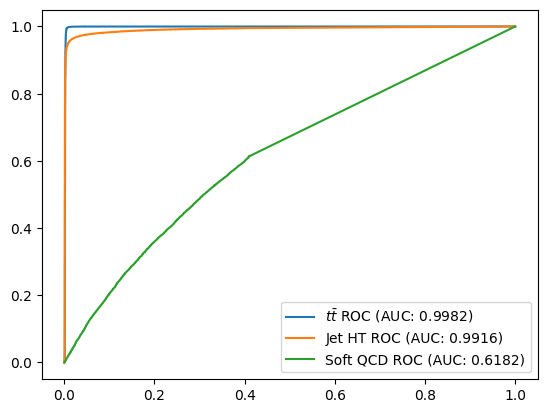

In [6]:
#
# Exercise: Evaluate the model you made in the previous section
#

def make_roc(background_scores, signal_scores, legend_label) -> None:
    y_true = np.append(
        np.ones(len(signal_scores)),
        np.zeros(len(background_scores)),
        axis=0
    )

    y_pred = np.append(
        signal_scores,
        background_scores,
        axis=0,
    )

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    plt.plot(
        fpr,
        tpr,
        label=f'{legend_label} ROC (AUC: {auc:.4})'
    )

zerobias_predictions = conv_ae.predict(zerobias_test)
ttbar_predictions = conv_ae.predict(ttbar_data)
jetht_predictions = conv_ae.predict(jetht_data)
softqcd_predictions = conv_ae.predict(softqcd_data)

def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred-y_true)**2, axis=(1,2,3))

zerobias_score = np.array(mean_squared_error(zerobias_test, zerobias_predictions))
ttbar_score = np.array(mean_squared_error(ttbar_data, ttbar_predictions))
jetht_score = np.array(mean_squared_error(jetht_data, jetht_predictions))
softqcd_score = np.array(mean_squared_error(softqcd_data, softqcd_predictions))

make_roc(zerobias_score, ttbar_score, legend_label=r'$t\bar{t}$')
make_roc(zerobias_score, jetht_score, legend_label=r'Jet HT')
make_roc(zerobias_score, softqcd_score, legend_label=r'Soft QCD')
plt.legend()


### Esoteric Losses

This section is also a little more freeform. I just wanted to take some time to introduce other loss functions than Mean Squared Error here. Mean Squared Error is not a bad loss, and should be your first stop in checking things when making reconstruction losses, but it also can reward "peak memorization" and out of set reconstruction if you aren't careful. For images like we're working with, you do have other options. These are things I am experimenting around with, so I figured it might be interesting for you all to take a look at them as well and see how they work for this exercise. No guaratees from my side that these will be suitable or usable. It is good practice to try implementing your own loss functions though, because the loss function really does shape the behavior of a neural network as much as the layers you put in it you may be called to really try exploring that as much as you would trying to put in more or fancier layers.

#### Huber Loss

The [Huber Loss](https://keras.io/api/losses/regression_losses/#huber-class) comes from the [Huber Function](https://en.wikipedia.org/wiki/Huber_loss) a piecewise combination of Mean Absolute Error and Mean Squared Error. The idea behind it is to try and prevent giving outliers outsize importance by the squared portion of Mean Squared Error. It applies Mean Absolute Error to get most values pretty close but not give large outliers outsized importance, and then Mean Squared Error closer to 0 so that it hones in the accuracy of those values that form the non-outlier elements. Keras provides an implementation of this loss for us to use. 

Why would you try to be impervious to outliers in our anomaly detection autoencoder? Well, if it gives a larger loss to outliers, and learns to reconstruct them better to minimize it, we're baking in the ability to reconstruct anomlies with our loss function!

#### Log-Cosh Loss

The Log-Cosh Loss is another loss similar to the Huber loss, but is not piece-wise. It is calculated as $\log{(e^{\hat{y}-y}+e^{y-\hat{y}})/2}$. It is designed to penalize outliers further out (the limit as the error grows large in either direction is functionally linear), and provide smooth gradients and training at all points. [Keras provides an implementation of this loss](https://keras.io/api/losses/regression_losses/#logcosh-class).

#### Normalized Cross Correlation

Normalized Cross Correlation is a metric between two signals or images (it doesn't necessarily have to be 2D) that measures the similarity of them, regardless of the amplitudes of the images. It rewards structural similarity over magnitude similarity. You can read a bit more [here](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), but in general, think of it as a function that is close to 1 if the two patterns have the same shape (but not necessarily the same overall amplitude).

It can be calculated like so:

$\frac{\sum{((x-\bar{x}) * (\hat{x}-\bar{\bar{x}}))}}{\sqrt{\sum{x-\bar{x}}^{2}} * \sqrt{\sum{\hat{x}-\bar{\hat{x}}}^{2}}}$

where $\hat{x}$ is our predicted value, and $x$ is the true value.

Since this grows with similarity instead of decreasing (i.e. it measures accuracy not error), but is bounded by 1.0, we can simply do $1-NCC$ as the actual loss function.

#### Structural Similarity Index

[Structural Similarity Index](https://en.wikipedia.org/wiki/Structural_similarity_index_measure) is a measure used in image transmission (television notably) to determine how similar a transmitted image looks to an observer. Rather than compare pizel by pizel though, it uses a lot of filtering and local structures to try and make a similarity judgement, even if the overall pixel values differ (In $MSE$ or $NCC$, an image shifted right by a few pixels could have a huge loss, but in structural similarity, it looks similar because the it maintains the variances and means roughly). The math behind it is a little more complicated, but nothing too terrible.

Tensorflow as part of the various image processing utilities it has, has an implementation of this, but to use it, it requires a filter size for the rough sizes of structures to look out for, and a max value difference between pixels.

#### Hybrid Losses

Once you get used to using custom losses, nothing is also preventing you from _blending_ loss functions. $\alpha*Loss_{1} + (1.0-\alpha)*Loss_{2}$.

I have included loss functions below for you to try out and look at. You may even notice that $MSE$ improves alongside some of these losses, or nothing prevents the two from being highly correlated

In [7]:
# Loss functions for you to use

import tensorflow as tf

huber_loss = keras.losses.Huber(delta=1.0)
huber_metric = keras.losses.Huber(delta=1.0, reduction=None) # for use in evaluation later

log_cosh_loss = keras.losses.LogCosh()
log_cosh_metric = keras.losses.LogCosh(reduction=None)

msle = keras.losses.MeanSquaredLogarithmicError()
msle_metric = keras.losses.MeanSquaredLogarithmicError(reduction=None)

def normalized_cross_correlation_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float64)
    y_pred = tf.cast(y_pred, dtype=tf.float64)

    x_mean = tf.reshape(tf.reduce_mean(y_true, axis=(1,2,3)), [-1,1,1,1])
    x_hat_mean = tf.reshape(tf.reduce_mean(y_pred, axis=(1,2,3)), [-1,1,1,1])

    x_minus_mean = y_true-x_mean
    x_hat_minus_mean = y_pred-x_hat_mean

    num = tf.reduce_sum(x_minus_mean * x_hat_minus_mean, axis=(1,2,3))
    denom = tf.math.sqrt(tf.reduce_sum(x_minus_mean**2, axis=(1,2,3)))*tf.math.sqrt(tf.reduce_sum(x_hat_minus_mean**2, axis=(1,2,3))) 

    return 1.0 - (num/(denom+1e-6))

def ssim_loss_fn(y_true, y_pred, filter_size=5, max_val=1.0):
    return 1.0 - tf.image.ssim(
        tf.cast(y_true, dtype=tf.float64),
        tf.cast(y_pred, dtype=tf.float64),
        filter_size=filter_size,
        max_val=max_val
    )

max_val_difference = np.max(zerobias_train) - np.min(zerobias_train)

ssim_loss = lambda y_true, y_pred: ssim_loss_fn(y_true, y_pred, filter_size=5, max_val=max_val_difference)

In [8]:
#
# Exercise: Make a seperate model with a different loss function
#

new_ae = keras.Sequential([
    #
    # encoder
    #
    keras.layers.Input(shape=zerobias_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(
        filters=16,
        kernel_size=7,
        padding='same',
        activation='leaky_relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    #Size is now 8 x 8, 16 filters
    keras.layers.SpatialDropout2D(0.2),
    keras.layers.Conv2D(
        filters=32,
        kernel_size=3,
        padding='same',
        activation='leaky_relu'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.GlobalMaxPooling2D(),
    #
    # Final latent space size and shape: 32 flat entries
    #
    # decoder
    #
    keras.layers.Dense(4*4*8, activation='leaky_relu'),
    keras.layers.Reshape((4,4,8)), #new shape is 4 x 4 with 8 features
    keras.layers.BatchNormalization(),
    keras.layers.SpatialDropout2D(0.2),

    #keras.layers.Conv2DTranspose(16, kernel_size=2, strides=2, activation='leaky_relu'), # new shape is 8 x 8 with 16 features
    keras.layers.Conv2DTranspose(16, kernel_size=5, strides=1, activation='leaky_relu'),
    keras.layers.BatchNormalization(),
    keras.layers.SpatialDropout2D(0.2),

    #keras.layers.Conv2DTranspose(32, kernel_size=2, strides=2, activation='leaky_relu'), # new shape is 16 x 16 with 32 features
    keras.layers.Conv2DTranspose(32, kernel_size=9, strides=1, activation='leaky_relu'),
    keras.layers.BatchNormalization(),
    keras.layers.SpatialDropout2D(0.2),

    keras.layers.Conv2D(5, kernel_size=5, padding='same'), # final shape is 16 x 16 with 5 features
])

new_ae.compile(
    optimizer='adam',
    loss=huber_loss,
    metrics=['mse', 'mae'],
)
new_ae.summary()

new_ae.fit(
    x=zerobias_data,
    y=zerobias_data,
    validation_data=(zerobias_val, zerobias_val),
    epochs=200,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_6           │ (None, 16, 16, 5)      │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 16)     │         3,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_4             │ (None, 8, 8, 16)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 4, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_5             │ (None, 4, 4, 8)        │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 8, 8, 16)       │         3,216 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_6             │ (None, 8, 8, 16)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 32)     │        41,504 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_7             │ (None, 16, 16, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 61,961 (242.04 KB)

 Trainable params: 61,743 (241.18 KB)

 Non-trainable params: 218 (872.00 B)

Epoch 1/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0357 - mae: 0.0902 - mse: 1.6835 - val_loss: 0.0154 - val_mae: 0.0267 - val_mse: 1.3203
Epoch 2/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0153 - mae: 0.0297 - mse: 1.4568 - val_loss: 0.0143 - val_mae: 0.0179 - val_mse: 1.3191
Epoch 3/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0145 - mae: 0.0224 - mse: 1.4850 - val_loss: 0.0143 - val_mae: 0.0175 - val_mse: 1.3206
Epoch 4/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0142 - mae: 0.0190 - mse: 1.0700 - val_loss: 0.0143 - val_mae: 0.0171 - val_mse: 1.3204
Epoch 5/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0144 - mae: 0.0183 - mse: 1.9622 - val_loss: 0.0143 - val_mae: 0.0171 - val_mse: 1.3199
Epoch 6/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0143 - mae: 0.0178 - mse: 1.3250 - val_loss: 0.0143 - val_mae: 0.0173 - val_mse: 1.3195
Epoch 7/200
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0144 - mae

In [10]:
new_ae.evaluate(zerobias_test, zerobias_test)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - mae: 0.0154 - mse: 2.0599


[0.011279867962002754, 2.0695488452911377, 0.015774421393871307]

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
2779/2779 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
6387/6387 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


(13991, 16, 16, 5)

(13991, 16, 16)

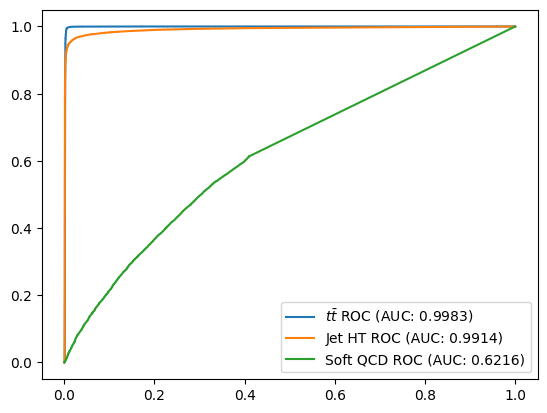

In [9]:
#
# Exercise: Compare this different loss function model to the previous model. Which works better?
#

new_zerobias_predictions = conv_ae.predict(zerobias_test)
new_ttbar_predictions = conv_ae.predict(ttbar_data)
new_jetht_predictions = conv_ae.predict(jetht_data)
new_softqcd_predictions = conv_ae.predict(softqcd_data)

test = huber_metric(zerobias_test, new_zerobias_predictions)
console.print(new_zerobias_predictions.shape)
console.print(test.shape)

new_zerobias_score = np.mean(np.array(huber_metric(zerobias_test, new_zerobias_predictions)), axis=(1,2))
new_ttbar_score = np.mean(np.array(huber_metric(ttbar_data, new_ttbar_predictions)), axis=(1,2))
new_jetht_score = np.mean(np.array(huber_metric(jetht_data, new_jetht_predictions)), axis=(1,2))
new_softqcd_score = np.mean(np.array(huber_metric(softqcd_data, new_softqcd_predictions)), axis=(1,2))

#new_zerobias_score = np.mean(np.array(log_cosh_metric(zerobias_test, new_zerobias_predictions)), axis=(1,2))
#new_ttbar_score = np.mean(np.array(log_cosh_metric(ttbar_data, new_ttbar_predictions)), axis=(1,2))
#new_jetht_score = np.mean(np.array(log_cosh_metric(jetht_data, new_jetht_predictions)), axis=(1,2))
#new_softqcd_score = np.mean(np.array(log_cosh_metric(softqcd_data, new_softqcd_predictions)), axis=(1,2))

#new_zerobias_score = normalized_cross_correlation_loss(zerobias_test, np.array(new_zerobias_predictions))
#new_ttbar_score = normalized_cross_correlation_loss(ttbar_data, np.array(new_ttbar_predictions))
#new_jetht_score = normalized_cross_correlation_loss(jetht_data, np.array(new_jetht_predictions))
#new_softqcd_score = normalized_cross_correlation_loss(softqcd_data, np.array(new_softqcd_predictions))

#new_zerobias_score = ssim_loss(zerobias_test, np.array(new_zerobias_predictions))
#new_ttbar_score = ssim_loss(ttbar_data, np.array(new_ttbar_predictions))
#new_jetht_score = ssim_loss(jetht_data, np.array(new_jetht_predictions))
#new_softqcd_score = ssim_loss(softqcd_data, np.array(new_softqcd_predictions))

make_roc(new_zerobias_score, new_ttbar_score, legend_label=r'$t\bar{t}$')
make_roc(new_zerobias_score, new_jetht_score, legend_label=r'Jet HT')
make_roc(new_zerobias_score, new_softqcd_score, legend_label=r'Soft QCD')
plt.legend()

### Different Networks for Anomaly Detection: Generative Adversarial Networks
Up to this point we have been focusing exclusively on different types of Autoencoder, because they form the most common and easiest to use idea in anomaly detection. They are not the only unsupervised technique in neural networks though, which means they are not the only technique in anomaly detection. The other big kind of network is the "Generative Adversarial Network". The idea goes like this: Generative Adversarial Networks actually use a pair of models, the first model is designed to take a bunch of noise/random numbers, and from this, it creates data that looks like the input dataset you are doing unsupervised learning on. The second model is a classifier, and its job is to judge whether the images it has gotten are genuinely from the dataset, or are fakes. The first model is trained to try and fool the second classifier model, the second classifier model is trained to try and find the genuine article and not get fooled.

At the end of training both of these models, the classifier then should be relatively picky and serve as a good judge of whether something belongs to the dataset it has seen, or is anomalous.

Because the training loop is a bit particular and odd, we can't actually use the standard `fit` function. I will provide the training loop, you provide the models. This training loop is also _very_ slow due to the amount of things that have to go on to get it to work (EDIT: Potentially also some memory issues with this?). It likely will not finish in the time we have. There is probably some optimization of things that happen here to make it a little less "by hand", but it should showcase the basic idea, which is what I want you to have. You should know that you can do anomaly detection with other neural networks, and there may even be some upsides to it.

In [9]:
#
# Exercise: Fill in the generator_model and classifier_model
#
from rich.progress import track

#Fill this in
#The generator model will need to take some random amount of noise as inputs
#But end up in our 16 x 16 with 5 features outputs
# I chose a flat input of size 4 * 4 * 2 = 32 noise inputs, that I reshape into 4 x 4 with 2 features
generator_model = keras.Sequential([
    keras.layers.Input(shape=(32,)),
    keras.layers.Reshape((4,4,2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(4, kernel_size=2, strides=2, activation='leaky_relu'), # 8 x 8 with 4 features
    keras.layers.SpatialDropout2D(0.2),
    keras.layers.Conv2DTranspose(5, kernel_size=2, strides=2) # 16 x 16 with 5 features
])

#This will run on the 16 x 16 with 5 features present in zero bias data
# or the generator model output
classifier_model = keras.Sequential([
    keras.layers.Input(shape=zerobias_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(
        8,
        kernel_size=7,
        activation='leaky_relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.SpatialDropout2D(0.2),

    keras.layers.Conv2D(
        16,
        kernel_size=3,
        activation='leaky_relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.SpatialDropout2D(0.2),

    keras.layers.GlobalMaxPooling2D(),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

batch_size=32
zerobias_gan_dataset = tf.data.Dataset.from_tensor_slices(zerobias_train).shuffle(1000)
zerobias_gan_dataset = zerobias_gan_dataset.batch(batch_size, drop_remainder=True).prefetch(1)

#TF can be a little funny about types it allows in training. Our dataset is double, it wants float
#This just quickly converts it
def cast_to_tf_float(x):
    return tf.cast(x, tf.dtypes.float32)
zerobias_gan_dataset = zerobias_gan_dataset.map(cast_to_tf_float)

gan = keras.models.Sequential([generator_model, classifier_model])

classifier_model.compile(loss='binary_crossentropy', optimizer='adam')
gan.compile(loss='binary_crossentropy', optimizer='adam')

def train_gan(gan, dataset, input_coding_size, n_epochs=5, batch_size=32):
    generator, classifier = gan.layers
    for epoch in range(n_epochs):
        console.print(f'Epoch: {epoch}')
        for x_batch in track(dataset):
            #Random noise to feed to the generator model
            noise = tf.random.normal(shape=[batch_size, input_coding_size])
            #First we train the classifier model by itself. To do that, we need some generated images
            #We generate that with the generator model and some noise. These won't be good at first
            #But we'll train the generator to fool the classifier soon
            generated_images = generator.predict(noise, verbose=0)
            #concatenate our fake images and genuine images together
            x_fake_and_real = tf.concat([generated_images, x_batch], axis=0)
            #Now we need our labels, beause we're training the classifier, the noise images should be 0, the genuine should be 1
            y1 = tf.concat([
                    tf.zeros((batch_size,)),
                    tf.ones((batch_size,)),
                ],
                axis=0
            )
            # Note, we could also provide labels that are not-directly 0 or 1, but close, like so: 
            # y1 = tf.concat(                                                                                                                            
            #   [                                                                                                                                      
            #    tf.math.abs(                                                                                                                       
            #       tf.random.normal(                                                                                                              
            #          mean=0.0,                                                                                                                  
            #          stddev = 0.1,                                                                                                              
            #          shape = [batch_size,]                                                                                                      
            #       )                                                                                                                              
            #    ),                                                                                                                                 
            #    1.0-tf.math.abs(                                                                                                                   
            #        tf.random.normal(                                                                                                              
            #          mean=0.0,                                                                                                                  
            #          stddev = 0.1,                                                                                                              
            #          shape = [batch_size,]                                                                                                      
            #        )                                                                                                                              
            #    ),                                                                                                                                 
            #   ],                                                                                                                                     
            #   axis=0,                                                                                                                                
            # )                          
            #in order to discourage the network from collapsing into poor equilibria. I'll talk about that in the next section
            #make sure the classifier is trainable (it will be deactivated later, so each loop we want to activate it again)
            classifier.trainable=True
            classifier.compile(loss='binary_crossentropy', optimizer='adam')
            #Actually train the classifier on the batch after all the setup!
            classifier.train_on_batch(x_fake_and_real, y1)

            #Okay, now we need to train the generator, the idea is, when we feed the entire generator+classifier chain noise,
            #The classifier should rate everything a 1, i.e. we think the fake images are genuine data
            #So generate some new noise, and 1 labels
            noise = tf.random.normal(shape=[batch_size, input_coding_size])
            y2 = tf.ones((batch_size,))
            # Now we need to avoid training the classifier while trying to train the generator
            # We don't want to train it one direction then the opposite
            classifier.trainable=False
            gan.compile(loss='binary_crossentropy', optimizer='adam')
            gan.train_on_batch(noise, y2)
    return gan

trained_gan = train_gan(gan, zerobias_gan_dataset, input_coding_size=32, n_epochs=1, batch_size=32)

#The classifier and generator can be split off into seperate models
#The classifier can be used for anomaly detection by evaluating on datasets as usual
#Depending on what you want to do, you can find a use for the generator too.

Epoch: 0

Output()

2025-06-13 11:40:56.286464: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.7 = (f32[64,16,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,8,5,5]{3,2,1,0} %bitcast.11344, f32[16,8,3,3]{3,2,1,0} %bitcast.10394, f32[16]{0} %bitcast.11414), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_5_1/conv2d_13_1/convolution" source_file="/afs/hep.wisc.edu/cms/aloeliger/anomalyTriggerWork/ADWorkshop/CMS_OpenData_Exercises/cms_opendata_exercises_env/lib64/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-13 11:41:00.300455: I external

KeyboardInterrupt: 

Generative Adversarial Networks are an interesting idea, and have some great upsides (a direct classifier trained to do almost exactly the task we are after, a free model that does generative stuff, etc.) but of course they are not without their downsides. The big one is the training loop, which has some problems that stem from game theory. Because these two networks are competing, they can end up in what is called a [Nash Equilibrium](https://en.wikipedia.org/wiki/Nash_equilibrium). A Nash Equilibrium is a scenario where neither network stands to gain from changing anymore, if the generator changes it will not fool the classifier any more than it already does, and potentially will become worse, and the classifier cannot be any better on the data it is seeing than it already is. Note, that being in this state does not guarantee that the generated images are any good, nor that the classifier is very accurate to our underlying dataset! Another potential issue involves the classifier and generator getting lost in very specific strategies that may not have much to do with generalization on the dataset. These issues are called "mode collapse".

There are some techniques to try and get around this. One is [SpectralNormalization](https://keras.io/api/layers/preprocessing_layers/numerical/spectral_normalization/) of layers. Another is adding some "fuzz" or "jitter" to the labels of the dataset (i.e. not using 0 or 1, but removing or adding a tiny bit to each) to try and force the networks out of stable states.

We won't have time to explore them here. That's homework, as is checking out the classifier's performance.

There are even techniques that attempt to blend the two ideas. One I was checking out yesterday was Adversarial Autoencoders (train an auto-encoder normally. Then have a classifier trained to tell the difference between the encoded latent space on the training set and a structured distribution like the normal distribution. In the third pass, train the encoding layer to attempt to fool the classifier (i.e. use the classifier to make the latent space follow the normal distribution) while hopefully retaining its recconstruction abilities. The whole setup provides new avenues for attempting to rate something as anomalous or not). Just be aware there are options beyond the basic!

### Wrap up

Barring some kind of LLM based autoencoder, we've covered a lot of the basics of most of the modern anomaly detection neural network methods. The only remaining major technique I would like to cover is Graph Neural Networks. We'll talk about those in the next exercise if we get time.